In [18]:
import torch
import os
import sys
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import Dataset
import random
from torch.optim import LBFGS
from pathlib import Path
from tqdm import tqdm
import wandb

# make sure that util is correctly accessed from parent directory
ppp_dir = os.path.abspath(os.path.join(os.getcwd(), "..", ".."))
if ppp_dir not in sys.path:
    sys.path.insert(0, ppp_dir)

from util import *
from model_parametrized.fls_parametrized import FLS_params

In [19]:
# Check if CUDA is available
cuda_available = torch.cuda.is_available()
print(f"CUDA available: {cuda_available}")

# If CUDA is available, print the CUDA version
if cuda_available:
    print(f"CUDA version: {torch.version.cuda}")
    print(f"Number of CUDA devices: {torch.cuda.device_count()}")
    print(f"Current CUDA device: {torch.cuda.current_device()}")
    print(f"CUDA device name: {torch.cuda.get_device_name(torch.cuda.current_device())}")

CUDA available: False


In [20]:
# set seeds and configure cuda device
seed = 0
np.random.seed(seed)
random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

In [21]:
class PDEData(Dataset):
    def __init__(self, x_range, t_range, rho_values, x_points, t_points):
        """
        Initialize the dataset for PDE data with multiple rho values.

        Args:
            x_range (list): Spatial domain [x_min, x_max].z
            t_range (list): Temporal domain [t_min, t_max].
            rho_values (list): List of rho values for different scenarios.
            x_points (int): Number of points in the spatial domain.
            t_points (int): Number of points in the temporal domain.
            device (str): Device to store the tensors ('cpu' or 'cuda').
        """
        self.device = "cpu"
        self.x_range = x_range
        self.t_range = t_range
        self.rho_values = rho_values  # Store multiple rho values
        self.x_points = x_points
        self.t_points = t_points
        
        # Generate the data for all rho values
        self.data = {}
        for rho in rho_values:
            res, b_left, b_right, b_upper, b_lower = self._generate_data()
            
            # Convert boundary points to PyTorch tensors
            b_left = torch.tensor(b_left, dtype=torch.float32, requires_grad=True).to(self.device)
            b_right = torch.tensor(b_right, dtype=torch.float32, requires_grad=True).to(self.device)
            b_upper = torch.tensor(b_upper, dtype=torch.float32, requires_grad=True).to(self.device)
            b_lower = torch.tensor(b_lower, dtype=torch.float32, requires_grad=True).to(self.device)
            
            self.data[rho] = {
                'res': torch.tensor(res, dtype=torch.float32, requires_grad=True).to(self.device),
                'b_left': b_left,
                'b_right': b_right,
                'b_upper': b_upper,
                'b_lower': b_lower,
                # Precompute analytical solutions for boundary points
                'u_left': self.analytical_solution(b_left[:, 0:1], b_left[:, 1:2], rho),
                'u_right': self.analytical_solution(b_right[:, 0:1], b_right[:, 1:2], rho),
                'u_upper': self.analytical_solution(b_upper[:, 0:1], b_upper[:, 1:2], rho),
                'u_lower': self.analytical_solution(b_lower[:, 0:1], b_lower[:, 1:2], rho),
            }
    
    def _generate_data(self):
        """
        Generate the interior and boundary points for the PDE.

        Returns:
            res (np.ndarray): Interior points.
            b_left, b_right, b_upper, b_lower (np.ndarray): Boundary points.
        """
        x = np.linspace(self.x_range[0], self.x_range[1], self.x_points)
        t = np.linspace(self.t_range[0], self.t_range[1], self.t_points)
        
        x_mesh, t_mesh = np.meshgrid(x, t)
        data = np.concatenate((np.expand_dims(x_mesh, -1), np.expand_dims(t_mesh, -1)), axis=-1)
        
        b_left = data[0, :, :] 
        b_right = data[-1, :, :]
        b_upper = data[:, -1, :]
        b_lower = data[:, 0, :]
        res = data.reshape(-1, 2)

        return res, b_left, b_right, b_upper, b_lower
    
    def analytical_solution(self, x, t, rho):
        """
        Compute the analytical solution u_ana(x, t, rho).

        Args:
            x (torch.Tensor): Spatial points.
            t (torch.Tensor): Temporal points.
            rho (float): Reaction coefficient.

        Returns:
            torch.Tensor: Analytical solution u(x, t, rho).
        """
        h = torch.exp(- (x - torch.pi)**2 / (2 * (torch.pi / 4)**2))
        return h * torch.exp(rho * t) / (h * torch.exp(rho * t) + 1 - h)
    
    def get_interior_points(self, rho):
        """
        Get the interior points (x_res, t_res, rho_res) for a specific rho.

        Args:
            rho (float): The rho value for the current scenario.

        Returns:
            x_res, t_res, rho_res (torch.Tensor): Interior points with rho values.
        """
        res = self.data[rho]['res']
        x_res, t_res = res[:, 0:1], res[:, 1:2]
        rho_res = torch.full_like(x_res, rho)  # Same shape, constant rho
        return x_res, t_res, rho_res
    
    def get_boundary_points(self, rho):
        """
        Get the boundary points (x_left, t_left, etc.) for a specific rho.

        Args:
            rho (float): The rho value for the current scenario.

        Returns:
            Boundary points (torch.Tensor): x, t, and rho values for all boundaries.
        """
        b_left = self.data[rho]['b_left']
        b_right = self.data[rho]['b_right']
        b_upper = self.data[rho]['b_upper']
        b_lower = self.data[rho]['b_lower']
        
        x_left, t_left = b_left[:, 0:1], b_left[:, 1:2]
        x_right, t_right = b_right[:, 0:1], b_right[:, 1:2]
        x_upper, t_upper = b_upper[:, 0:1], b_upper[:, 1:2]
        x_lower, t_lower = b_lower[:, 0:1], b_lower[:, 1:2]
        
        rho_left = torch.full_like(x_left, rho)
        rho_right = torch.full_like(x_right, rho)
        rho_upper = torch.full_like(x_upper, rho)
        rho_lower = torch.full_like(x_lower, rho)
        
        return x_left, t_left, rho_left, x_right, t_right, rho_right, x_upper, t_upper, rho_upper, x_lower, t_lower, rho_lower
    
    def get_boundary_values(self, rho):
        """
        Get the precomputed analytical solutions for the boundary points.

        Args:
            rho (float): The rho value for the current scenario.

        Returns:
            u_left, u_right, u_upper, u_lower (torch.Tensor): Analytical solutions at the boundaries.
        """
        return (self.data[rho]['u_left'], self.data[rho]['u_right'], 
                self.data[rho]['u_upper'], self.data[rho]['u_lower'])
    
    def get_test_points(self, rho):
        """
        Get the test points (res_test) and their spatial and temporal components for a specific rho.

        Args:
            rho (float): The rho value for the current scenario.

        Returns:
            res_test (torch.Tensor): Test points as a tensor.
            x_test, t_test, rho_test (torch.Tensor): Spatial, temporal, and rho components of the test points.
        """
        res_test = self.data[rho]['res']
        x_test, t_test = res_test[:, 0:1], res_test[:, 1:2]
        rho_test = torch.full_like(x_test, rho)  # Same shape, constant rho
        return res_test, x_test, t_test, rho_test

In [25]:
### setting configuration parameters and logging via wandb
total_i = 100
model_name = "fls_extended" 
in_dim = 3 
hidden_dim = 512 
out_dim=1
num_layer=4
bias_fill = 0.01

config_dict = {
    "total_i": total_i,
    "model": model_name,
    "in_dim": in_dim,
    "hidden_dim": hidden_dim, 
    "out_dim": out_dim, 
    "num_layer": num_layer,
    "init_weights": "xavier uniform", 
    "bias_fill": bias_fill,
    "optimizer": "LBFGS"
}

run = wandb. init(
    project="pinnsformer",
    config=config_dict,
    settings=wandb.Settings(silent=True)
)

In [26]:
# Train PINNs 
def init_weights(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.xavier_uniform(m.weight)
        m.bias.data.fill_(config_dict["bias_fill"])
        
model = FLS_params(in_dim=config_dict["in_dim"], hidden_dim=config_dict["hidden_dim"], out_dim=config_dict["out_dim"], num_layer=config_dict["num_layer"]).to(device)

model.apply(init_weights)
optim = LBFGS(model.parameters(), line_search_fn='strong_wolfe')

print(model)
print(get_n_params(model))

FLS_params(
  (linear): Sequential(
    (0): Linear(in_features=3, out_features=512, bias=True)
    (1): SinAct()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): Tanh()
    (4): Linear(in_features=512, out_features=512, bias=True)
    (5): Tanh()
    (6): Linear(in_features=512, out_features=1, bias=True)
  )
)
527873


/var/folders/05/2lz5pq396gxgltyzndb50dp00000gn/T/ipykernel_58309/398557412.py:4: FutureWarning: `nn.init.xavier_uniform` is now deprecated in favor of `nn.init.xavier_uniform_`.
  torch.nn.init.xavier_uniform(m.weight)


In [27]:
# Define rho values
rho_values = [4.0, 5.0, 6.0]  
#rho_values = [5.0]
total_i = config_dict["total_i"]

# Create the dataset
dataset = PDEData(x_range=[0, 2 * torch.pi], t_range=[0, 1], rho_values=rho_values, x_points=101, t_points=101)

# Training loop
loss_track = {i: {} for i in range(total_i)}  # Initialize a dictionary for tracking losses

for i in tqdm(range(total_i)):
    for rho in rho_values:
        def closure():
            # Get interior points
            x_res, t_res, rho_res = dataset.get_interior_points(rho)
            
            # Get boundary points
            x_left, t_left, rho_left, x_right, t_right, rho_right, x_upper, t_upper, rho_upper, x_lower, t_lower, rho_lower = dataset.get_boundary_points(rho)
            u_left, u_right, u_upper, u_lower = dataset.get_boundary_values(rho)
            
            # Get analytical solution for the initial condition (t = 0)
            u_ic = dataset.analytical_solution(x_lower, t_lower, rho)  # t_lower corresponds to t = 0
            
            # Model predictions
            pred_res = model(x_res, t_res, rho_res)
            pred_left = model(x_left, t_left, rho_left)
            pred_right = model(x_right, t_right, rho_right)
            pred_upper = model(x_upper, t_upper, rho_upper)
            pred_lower = model(x_lower, t_lower, rho_lower)

            # Compute derivatives
            u_x = torch.autograd.grad(pred_res, x_res, grad_outputs=torch.ones_like(pred_res), retain_graph=True, create_graph=True)[0]
            u_t = torch.autograd.grad(pred_res, t_res, grad_outputs=torch.ones_like(pred_res), retain_graph=True, create_graph=True)[0]

            # Compute losses
            loss_res = torch.mean((u_t - rho * pred_res * (1 - pred_res)) ** 2)
            loss_bc = torch.mean((pred_upper - pred_lower) ** 2)  # Compare predictions at t = 0 to analytical solution
            loss_ic = torch.mean((pred_left[:,0] - u_left[:,0]) ** 2)  # Initial condition loss

            # Total loss
            loss = loss_res + loss_bc + loss_ic

            wandb.log({"loss": loss.item(), "loss_res": loss_res.item(), "loss_bc": loss_bc.item(), "loss_ic": loss_ic.item(), "iteration": i, "rho": rho})

            # Store losses in loss_track
            if rho not in loss_track[i]:
                loss_track[i][rho] = {}
            loss_track[i][rho]["loss_res"] = loss_res.item()
            loss_track[i][rho]["loss_bc"] = loss_bc.item()
            loss_track[i][rho]["loss_ic"] = loss_ic.item()

            optim.zero_grad()
            loss.backward(retain_graph=True)
            return loss

        optim.step(closure)

wandb.finish()

100%|██████████| 100/100 [22:32<00:00, 13.53s/it]


In [28]:
from pathlib import Path

In [29]:
base_dir = Path(".")  # Base directory for results
images_dir = base_dir / "images"  # Subdirectory for images
weights_dir = base_dir / "weights"  # Subdirectory for stored model

# Create the directories if they don't exist
images_dir.mkdir(parents=True, exist_ok=True)
weights_dir.mkdir(parents=True, exist_ok=True)

In [30]:
# Print losses for the last iteration and a specific rho value
last_iteration = total_i - 1
for rho in rho_values:
    print('Rho: {:4f}, Loss Res: {:4f}, Loss BC: {:4f}, Loss IC: {:4f}'.format(
        rho,
        loss_track[last_iteration][rho]["loss_res"],
        loss_track[last_iteration][rho]["loss_bc"],
        loss_track[last_iteration][rho]["loss_ic"]
    ))
    print('Train Loss: {:4f}'.format(
        loss_track[last_iteration][rho]["loss_res"] +
        loss_track[last_iteration][rho]["loss_bc"] +
        loss_track[last_iteration][rho]["loss_ic"]
    ))

model_path = weights_dir / "1d_reaction_fls_extended.pt"
torch.save(model.state_dict(), model_path)

Rho: 4.000000, Loss Res: 0.024111, Loss BC: 0.000006, Loss IC: 0.169419
Train Loss: 0.193536
Rho: 5.000000, Loss Res: 0.019435, Loss BC: 0.000004, Loss IC: 0.179781
Train Loss: 0.199219
Rho: 6.000000, Loss Res: 0.032464, Loss BC: 0.000503, Loss IC: 0.184590
Train Loss: 0.217557


In [31]:
# Initialize storage for errors
errors = []

# Loop over each rho value
for rho in rho_values:
    # Get test points for the current rho
    res_test, x_test, t_test,_ = dataset.get_test_points(rho)
    rho_test = torch.full_like(x_test, rho).to(device)  # Create rho tensor for test points

    # Compute the analytical solution for the test points
    u_analytical = dataset.analytical_solution(x_test, t_test, rho).cpu().detach().numpy().reshape(101, 101)

    # Convert test points to PyTorch tensors
    res_test = res_test.to(device)

    # Model predictions
    with torch.no_grad():
        pred = model(x_test.to(device), t_test.to(device), rho_test.to(device))[:, 0:1]
        pred = pred.cpu().detach().numpy().reshape(101, 101)

    # Compute relative errors
    rl1 = np.sum(np.abs(u_analytical - pred)) / np.sum(np.abs(u_analytical))
    rl2 = np.sqrt(np.sum((u_analytical - pred) ** 2) / np.sum(u_analytical ** 2))

    print(f"Rho: {rho}, Relative L1 error: {rl1:.4f}, Relative L2 error: {rl2:.4f}")
    errors.append((rho, rl1, rl2))

Rho: 4.0, Relative L1 error: 0.9396, Relative L2 error: 0.9228
Rho: 5.0, Relative L1 error: 0.9521, Relative L2 error: 0.9595
Rho: 6.0, Relative L1 error: 1.0049, Relative L2 error: 1.0112


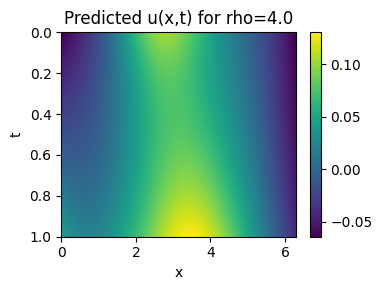

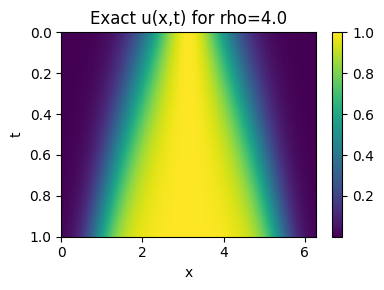

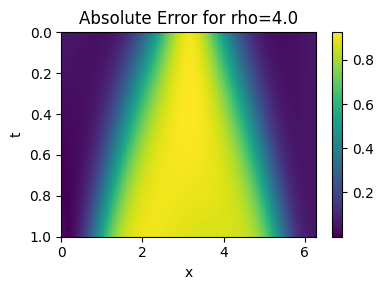

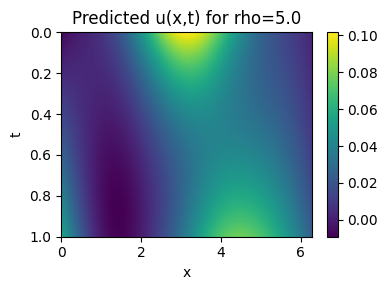

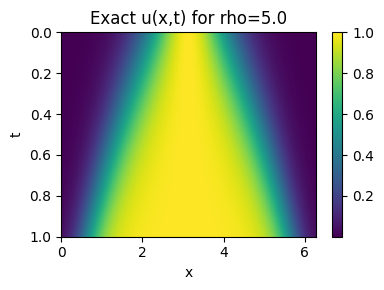

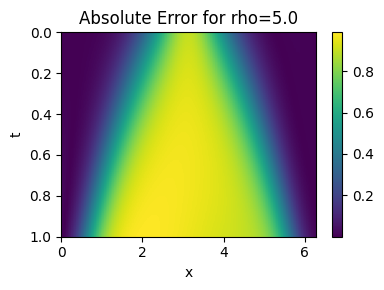

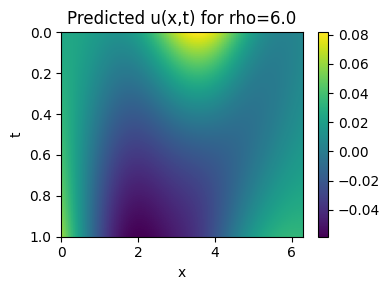

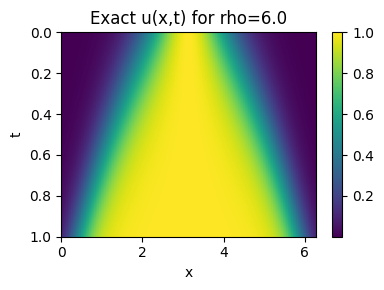

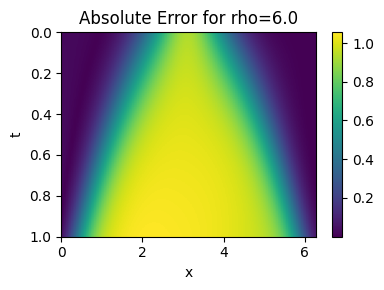

In [33]:
# Visualization for each rho value
for rho in rho_values:
    # Get test points for the current rho
    res_test, x_test, t_test, _ = dataset.get_test_points(rho)
    rho_test = torch.full_like(x_test, rho).to(device)

    # Compute the analytical solution for the test points
    u_analytical = dataset.analytical_solution(x_test, t_test, rho).cpu().detach().numpy().reshape(101, 101)

    # Model predictions
    with torch.no_grad():
        pred = model(x_test.to(device), t_test.to(device), rho_test.to(device))[:, 0:1]
        pred = pred.cpu().detach().numpy().reshape(101, 101)

    # Absolute error
    abs_error = np.abs(u_analytical - pred)

    # Plot predicted solution
    plt.figure(figsize=(4, 3))
    plt.imshow(pred, extent=[0, torch.pi * 2, 1, 0], aspect='auto')
    plt.xlabel('x')
    plt.ylabel('t')
    plt.title(f'Predicted u(x,t) for rho={rho}')
    plt.colorbar()
    plt.tight_layout()
    plot_path = images_dir / f"1d_reaction_fls_pred_rho-{rho}.png"
    plt.savefig(plot_path)
    plt.show()

    # Plot analytical solution
    plt.figure(figsize=(4, 3))
    plt.imshow(u_analytical, extent=[0, torch.pi * 2, 1, 0], aspect='auto')
    plt.xlabel('x')
    plt.ylabel('t')
    plt.title(f'Exact u(x,t) for rho={rho}')
    plt.colorbar()
    plt.tight_layout()
    plot_path = images_dir / f"1d_reaction_fls_exact_rho-{rho}.png"
    plt.savefig(plot_path)
    plt.show()

    # Plot absolute error
    plt.figure(figsize=(4, 3))
    plt.imshow(abs_error, extent=[0, torch.pi * 2, 1, 0], aspect='auto')
    plt.xlabel('x')
    plt.ylabel('t')
    plt.title(f'Absolute Error for rho={rho}')
    plt.colorbar()
    plt.tight_layout()
    plot_path = images_dir / f"1d_reaction_fls_error_rho-{rho}.png"
    plt.savefig(plot_path)
    plt.show()